In [1]:
import toml
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sqlalchemy as sa
import datetime
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

sns.set_theme()

In [2]:
config = toml.load("./db.toml")['psql']
connection_string = f"postgresql://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

In [3]:
conn = sa.create_engine(connection_string)

In [4]:
def cdf(series: pd.Series) -> pd.DataFrame:
    """ calculates the cumulative distribution function of the given series"""
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [5]:
sns.set_theme()
dpi = 150

In [6]:
df_runs = pd.read_sql_query("SELECT * FROM runs", con=conn)

In [7]:
start_date = '2023-03-20'
end_date = '2023-03-27'

In [29]:
query = f"""
SELECT
    r.region,
    m.website,
    m.url,
    m.type,
    m.try,
    EXTRACT(EPOCH FROM m.ttfb) ttfb,
    EXTRACT(EPOCH FROM m.fcp) fcp,
    EXTRACT(EPOCH FROM m.lcp) lcp
FROM measurements m
    INNER JOIN runs r on m.run_id = r.id
WHERE (m.error IS NULL OR m.error = 'window.requestIdleCallback timed out')
  AND m.type = 'KUBO'
  AND m.created_at >= '{start_date}'
  AND m.created_at < '{end_date}'
"""
df_measurements = pd.read_sql_query(query, con=conn)

In [30]:
data = df_measurements.copy()
data.head()

,region,website,url,type,try,ttfb,fcp,lcp
0,us-west-1,consensuslab.world,http://localhost:8080/ipns/consensuslab.world,KUBO,0,1.2974,1.8469,1.9970
1,us-west-1,docs.libp2p.io,http://localhost:8080/ipns/docs.libp2p.io,KUBO,0,0.6320,1.1900,1.1900
2,us-west-1,ipfs.tech,http://localhost:8080/ipns/ipfs.tech,KUBO,0,0.1803,0.2765,0.5178
3,sa-east-1,consensuslab.world,http://localhost:8080/ipns/consensuslab.world,KUBO,0,2.0100,3.2199,3.8298
4,us-west-1,web3.storage,http://localhost:8080/ipns/web3.storage,KUBO,0,2.1307,3.3510,3.3510


In [31]:
def get_percentiles(data: pd.DataFrame, percentile: float = 0.5, metric: str = "fcp"):
    agg = data[["website", "region", metric]] \
        .groupby(["website", "region"]) \
        .quantile(percentile, numeric_only=True).reset_index()

    row_labels = list(sorted(agg["region"].unique()))
    col_labels = list(sorted(agg["website"].unique()))
    dat = []
    counts = []
    for region in row_labels:
        region_values = []
        region_counts = []
        for website in col_labels:
            region_counts += [data[(data["region"] == region) & (data["website"] == website)].count().iloc[0]]
            series = agg[(agg["region"] == region) & (agg["website"] == website)][metric]
            if len(series) > 0:
                region_values += [series.iloc[0]]
            else:
                region_values += [np.NAN]
        dat += [region_values]
        counts += [region_counts]
    dat = np.array(dat)
    counts = np.array(counts)
    return dat, counts, row_labels, col_labels

In [32]:
def plot_metric(title: str, metric: str):
    fig, axes = plt.subplots(3, 1, figsize=[17, 17])

    pos = None
    for idx, percentile in enumerate([0.5, 0.9, 0.99]):
        cbar_kw = {}

        dat, counts, row_labels, col_labels = get_percentiles(data, percentile, metric)
        # dat_prev, counts_prev, row_labels_prev, col_labels_prev = get_percentiles(data_prev, percentile, metric)

        ax = fig.axes[idx]

        im = ax.imshow(dat, cmap=sns.color_palette("rocket_r", as_cmap=True))

        # Create colorbar
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(f"p{int(percentile * 100)} Latency in Seconds", rotation=-90, va="bottom")

        # Show all ticks and label them with the respective list entries.
        if idx == 0:
            ax.set_title(title)
            ax.set_xticks(np.arange(dat.shape[1]), labels=col_labels)
        else:
            ax.set_xticks([], labels=[])

        ax.set_yticks(np.arange(dat.shape[0]), labels=row_labels)

        # Let the horizontal axes labeling appear on top.
        ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

        # Turn spines off and create white grid.
        ax.spines[:].set_visible(False)

        ax.set_xticks(np.arange(dat.shape[1] + 1) - .5, minor=True)
        ax.set_yticks(np.arange(dat.shape[0] + 1) - .5, minor=True)
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

        threshold = im.norm(dat.max()) / 2.
        textcolors = ("#212121", "white")
        kw = dict(ha="center", va="center")
        fmtr = mpl.ticker.StrMethodFormatter("{x:.3f}")
        for i in range(dat.shape[0]):
            for j in range(dat.shape[1]):
                tc = textcolors[int(im.norm(dat[i, j]) > threshold)]
                kw.update(color=tc)
                im.axes.text(j, i, fmtr(dat[i, j]), **kw)
                # im.axes.text(j + 0.5, i + 0.5, counts[i, j], ha="right", va="bottom", color=tc, fontsize=8)

                # try:
                #     i_prev = row_labels_prev.index(row_labels[i])
                #     j_prev = col_labels_prev.index(col_labels[j])
                #     im.axes.text(j + 0.5, i + 0.5, "%.1f%%" % (100 * (dat[i, j] / dat_prev[i_prev, j_prev] - 1)),
                #                  ha="right", va="bottom", color=tc, fontsize=8)
                # except ValueError:
                #     im.axes.text(j + 0.5, i + 0.5, "-", ha="right", va="bottom", color=tc, fontsize=10)

        ax.text(-2, -1.5 if idx == 0 else -0.5, f"p{int(percentile * 100)}", ha="left", va="top", fontweight="bold",
                fontsize="large")

        if idx == 2:
            for j, count in enumerate(np.sum(counts, axis=0)):
                ax.text(j, 6.6, f"Samples\n{count}", ha="center", va="top", fontsize=8)

    fig.tight_layout()

    return fig

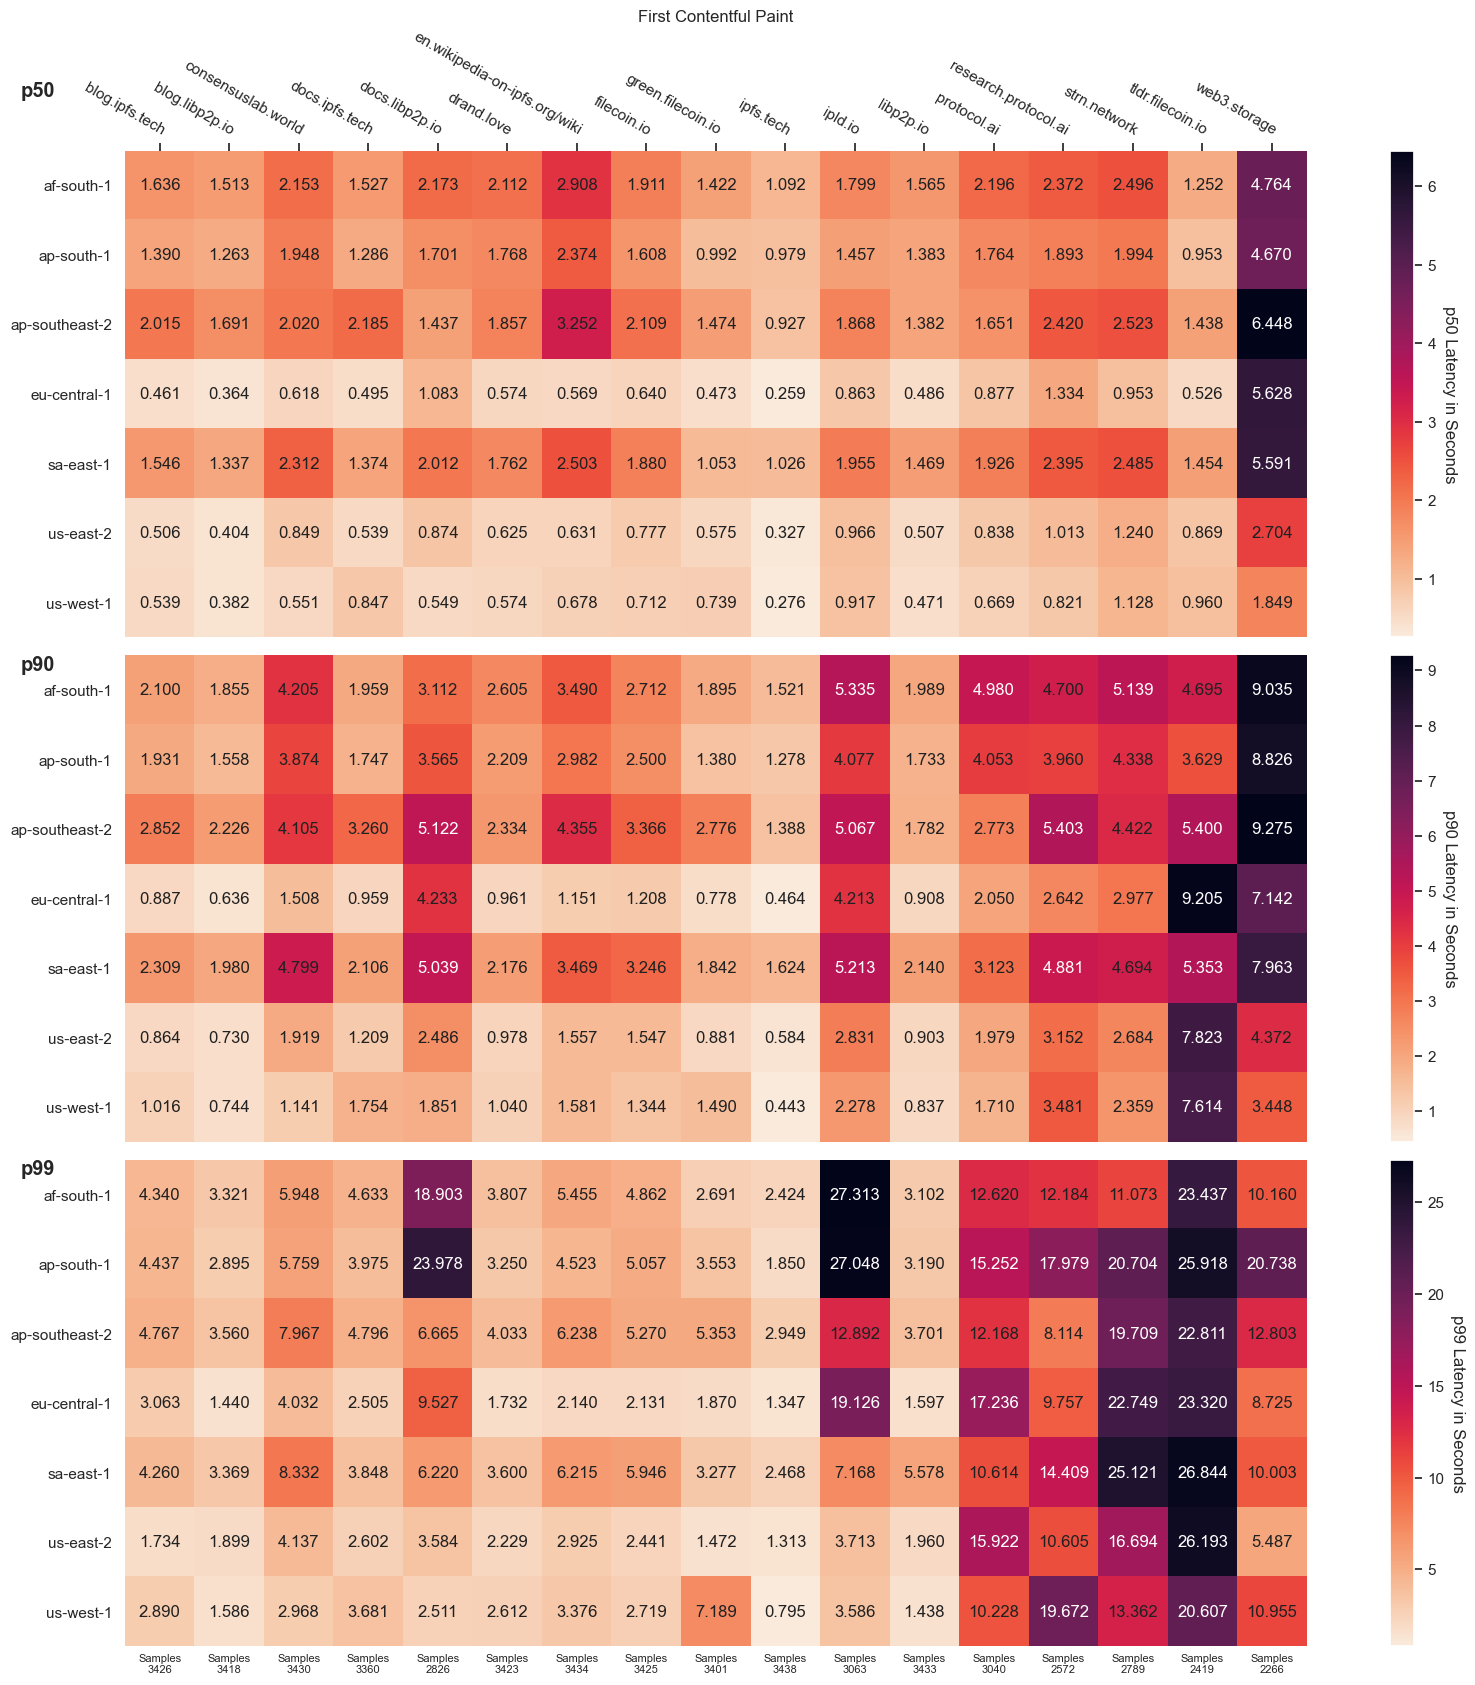

In [33]:
plot_metric("First Contentful Paint", "fcp");

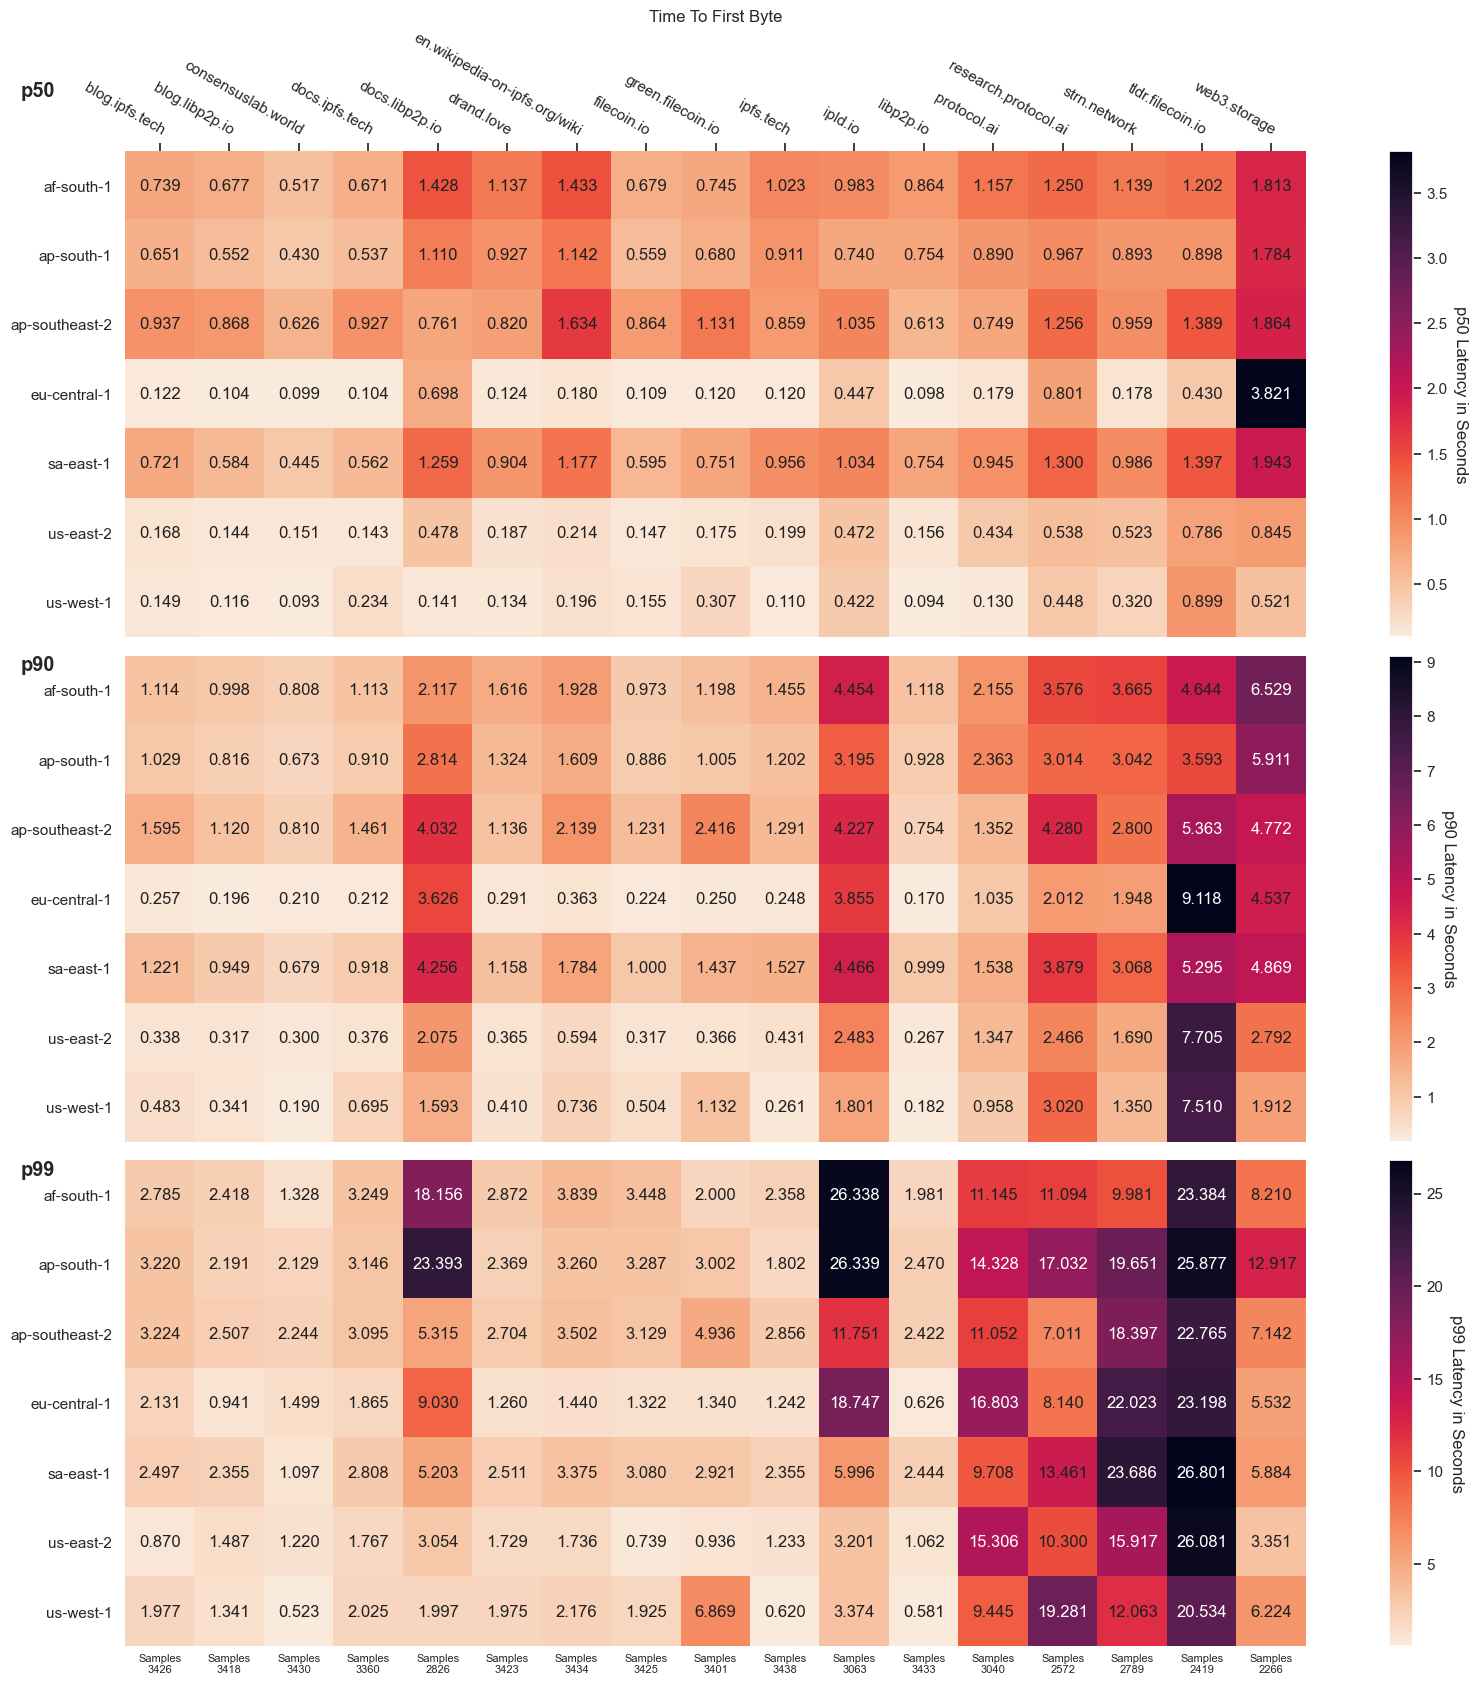

In [34]:
plot_metric("Time To First Byte", "ttfb");

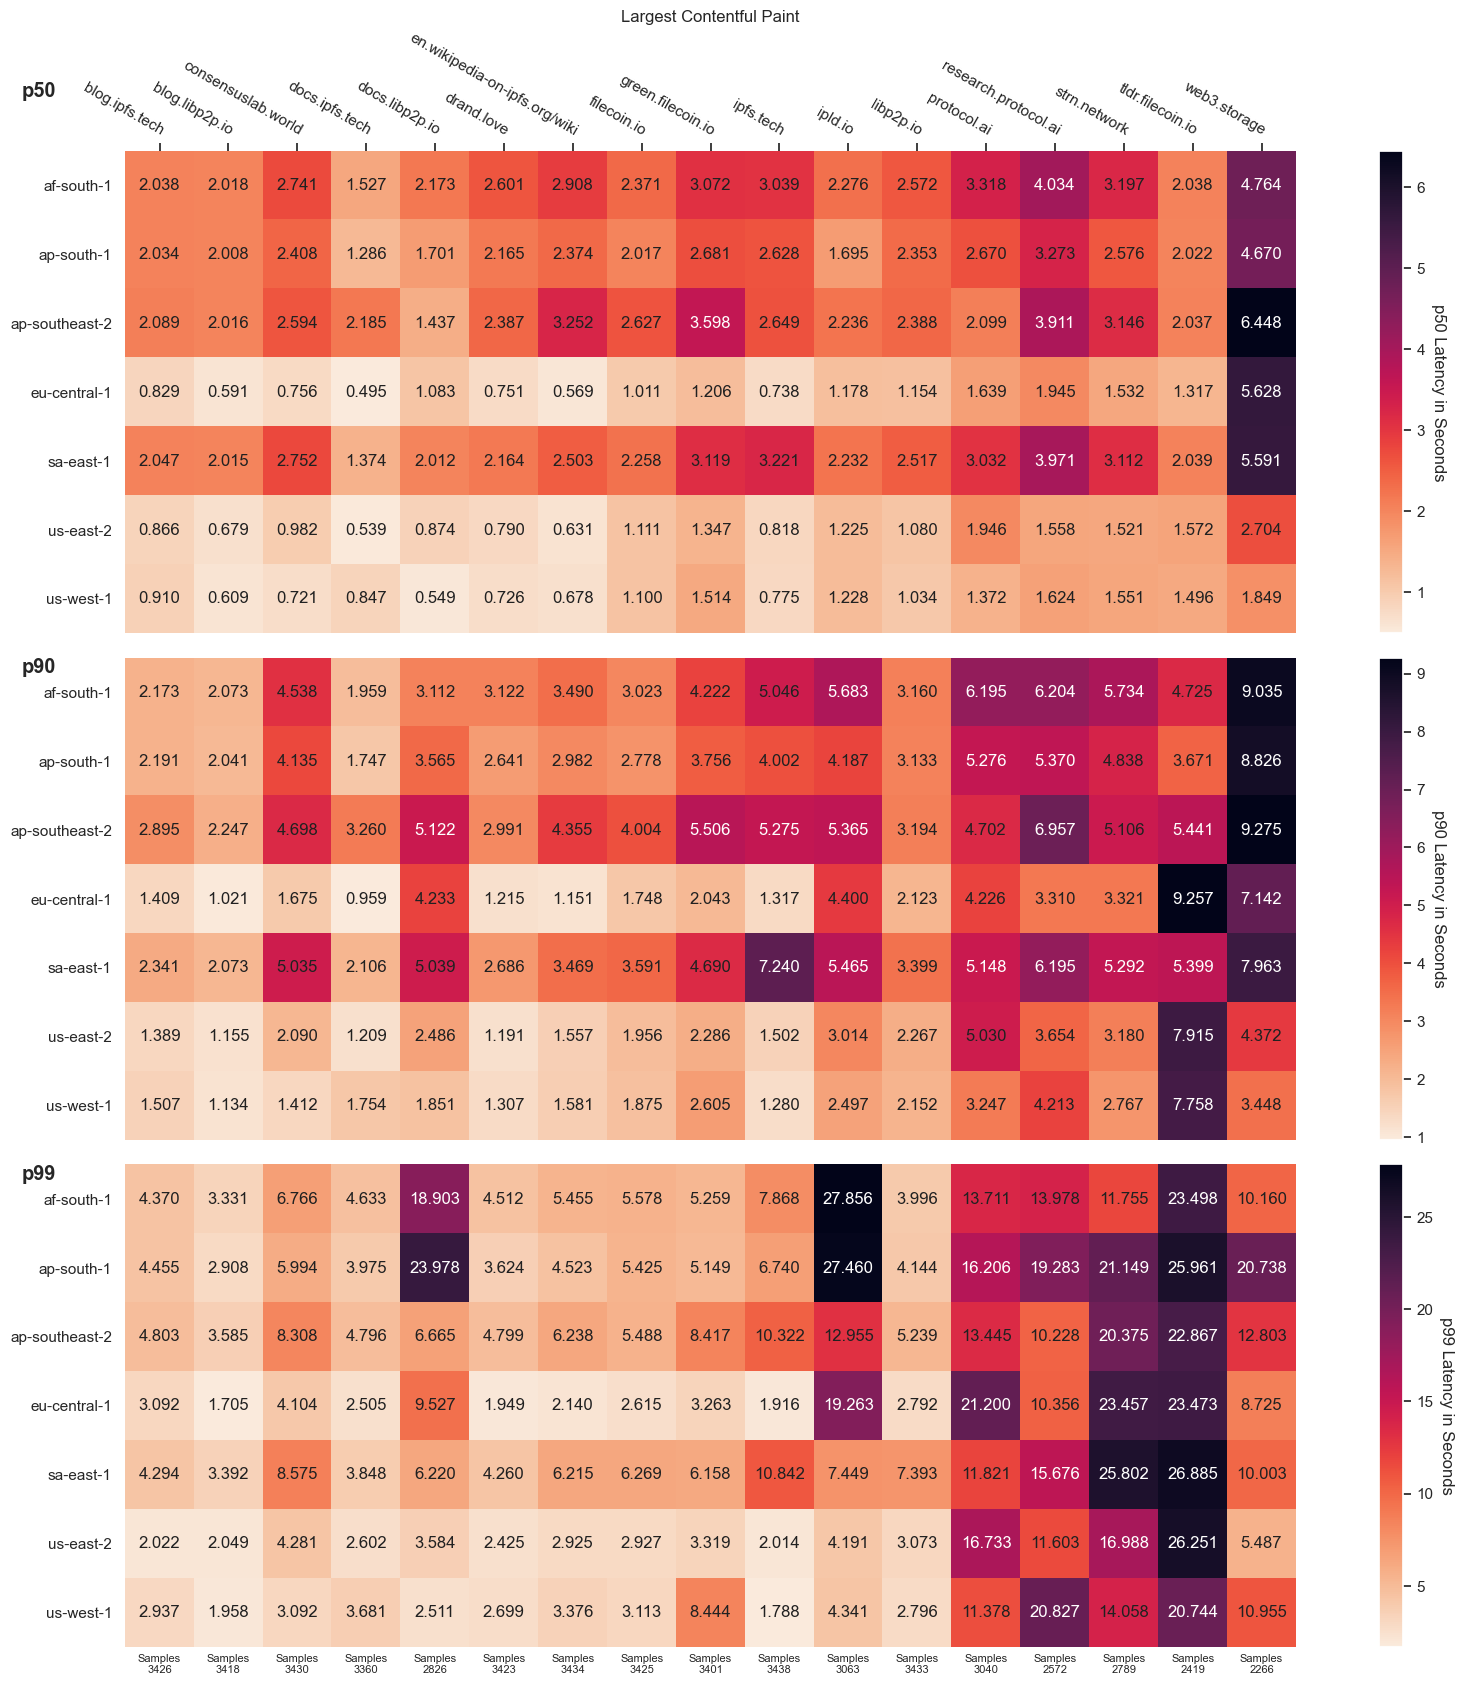

In [35]:
plot_metric("Largest Contentful Paint", "lcp");

In [41]:
query = f"""
SELECT
    m.id,
    r.region,
    m.website,
    m.url,
    m.type,
    m.try,
    CASE
        WHEN m.error = 'navigation timed out' THEN
            m.error
        ELSE
            NULL
    END,
    m.created_at
FROM measurements m
    INNER JOIN runs r on m.run_id = r.id
WHERE m.type = 'KUBO'
  AND m.created_at >= '{start_date}'
  AND m.created_at < '{end_date}'
"""
df_measurements = pd.read_sql_query(query, con=conn)

In [42]:
df_measurements = pd.concat([df_measurements, df_measurements["error"].notnull().rename("has_error")], axis=1)

KeyError: 'error'

In [ ]:
data = df_measurements \
    .groupby([df_measurements.created_at.dt.floor('d'), "has_error", "website"]) \
    .count() \
    .drop("created_at", axis=1).reset_index()

In [ ]:
dat = data[(data["website"] == "web3.storage")].copy()
dat["%"] = 100 * dat["id"] / dat.groupby("created_at")["id"].transform("sum")
dat.groupby("created_at").sum(numeric_only=True)["id"]

Text(0, 0.5, 'Daily Error Rate in % of All Website Requests / day')

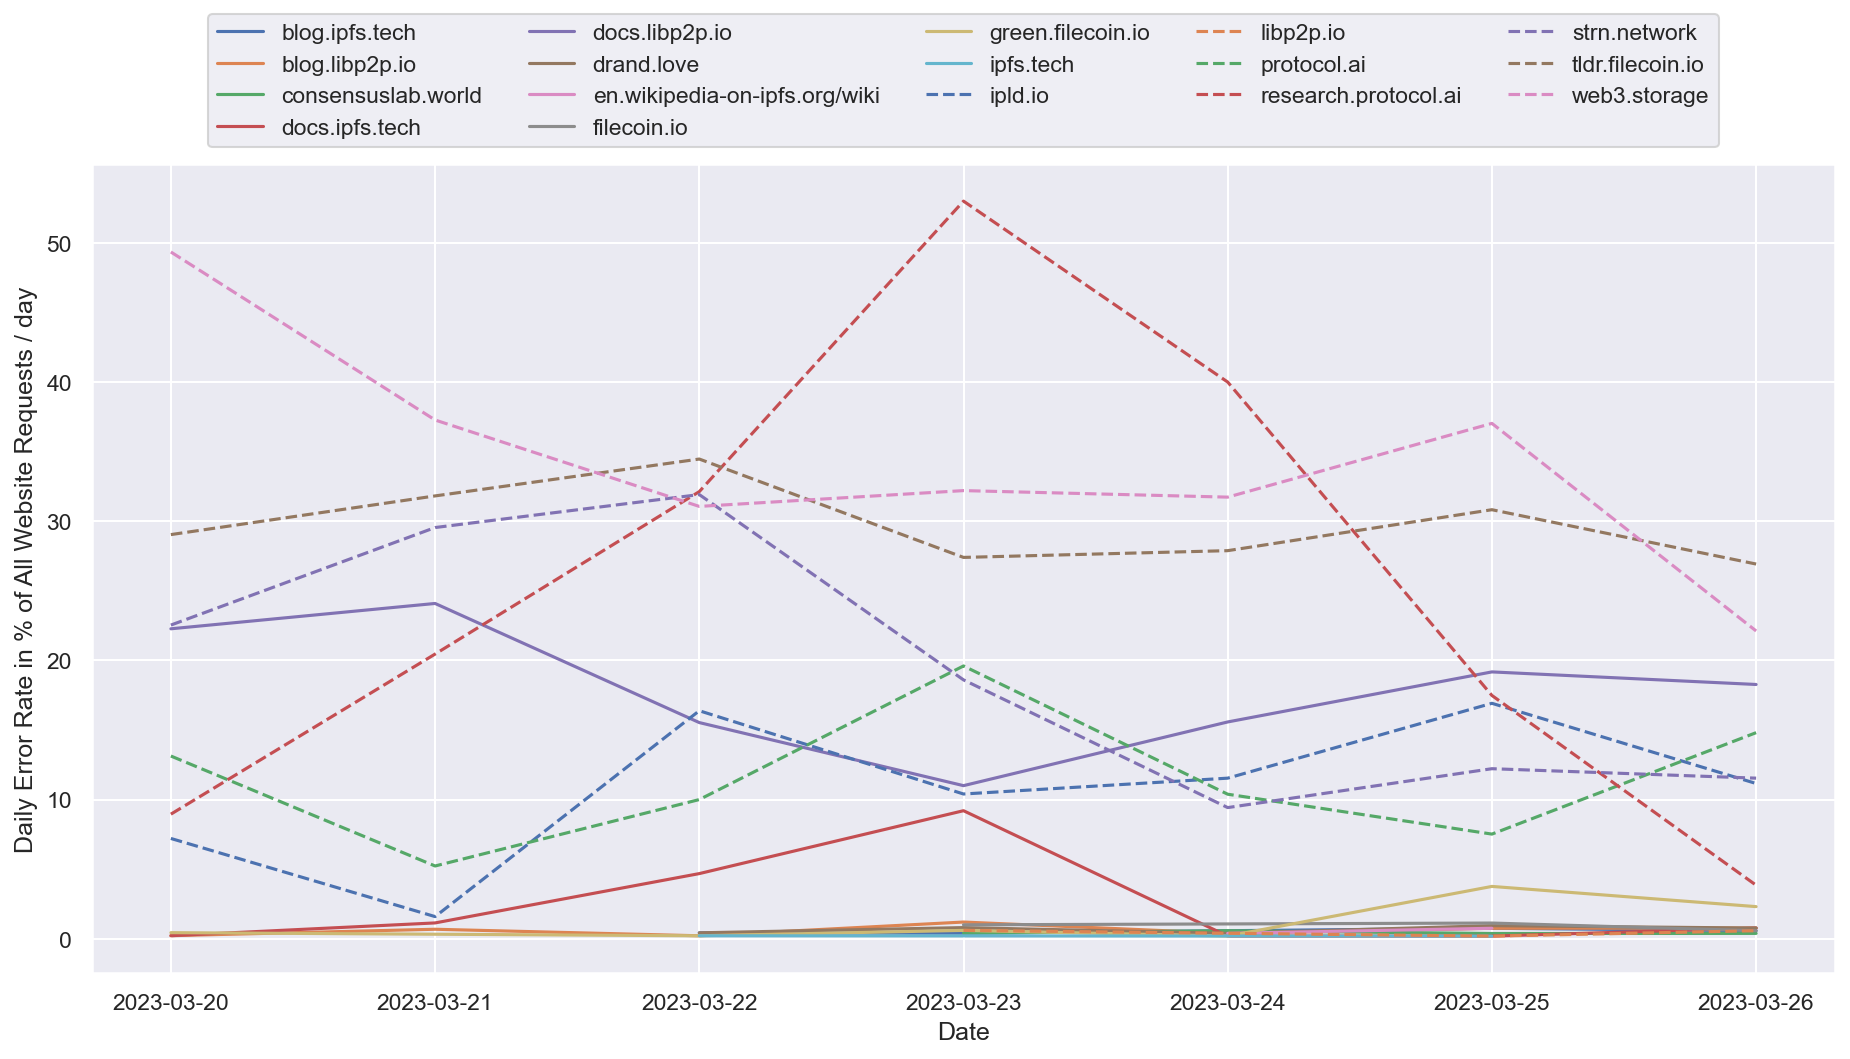

In [44]:
fig, ax = plt.subplots(figsize=[15, 7], dpi=150)

for j, website in enumerate(sorted(data["website"].unique())):
    ls = "solid"
    if j >= 10:
        ls = "dashed"
    dat = data[data["website"] == website].copy()
    dat["%"] = 100 * dat["id"] / dat.groupby("created_at")["id"].transform("sum")
    dat = dat[dat["has_error"]]

    ax.plot(dat["created_at"], dat["%"], ls=ls, label=website)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=5)
ax.set_xlabel("Date")
ax.set_ylabel("Daily Error Rate in % of All Website Requests / day")

In [46]:
query = f"""
SELECT
    m.id,
    r.region,
    m.website,
    m.url,
    m.type,
    m.try,
    m.error,
    EXTRACT(EPOCH FROM m.ttfb) ttfb,
    EXTRACT(EPOCH FROM m.fcp) fcp,
    EXTRACT(EPOCH FROM m.lcp) lcp,
    m.created_at
FROM measurements m
    INNER JOIN runs r on m.run_id = r.id
WHERE m.error IS NULL
  AND m.created_at >= '{start_date}'
  AND m.created_at < '{end_date}'
"""
df_query = pd.read_sql_query(query, con=conn)

In [47]:
df = df_query.copy()
df = df.groupby([df.created_at.dt.floor('d'), "website", "region", "type"]).median(numeric_only=True).reset_index()[
    ["created_at", "website", "region", "type", "ttfb"]]
df

,created_at,website,region,type,ttfb
0,2023-03-20 00:00:00+00:00,blog.ipfs.tech,af-south-1,HTTP,0.71760
1,2023-03-20 00:00:00+00:00,blog.ipfs.tech,af-south-1,KUBO,0.72910
2,2023-03-20 00:00:00+00:00,blog.ipfs.tech,ap-south-1,HTTP,0.34785
3,2023-03-20 00:00:00+00:00,blog.ipfs.tech,ap-south-1,KUBO,0.59390
4,2023-03-20 00:00:00+00:00,blog.ipfs.tech,ap-southeast-2,HTTP,0.30345
...,...,...,...,...,...
1623,2023-03-26 00:00:00+00:00,web3.storage,sa-east-1,KUBO,2.45200
1624,2023-03-26 00:00:00+00:00,web3.storage,us-east-2,HTTP,0.06395
1625,2023-03-26 00:00:00+00:00,web3.storage,us-east-2,KUBO,0.80540
1626,2023-03-26 00:00:00+00:00,web3.storage,us-west-1,HTTP,0.03490


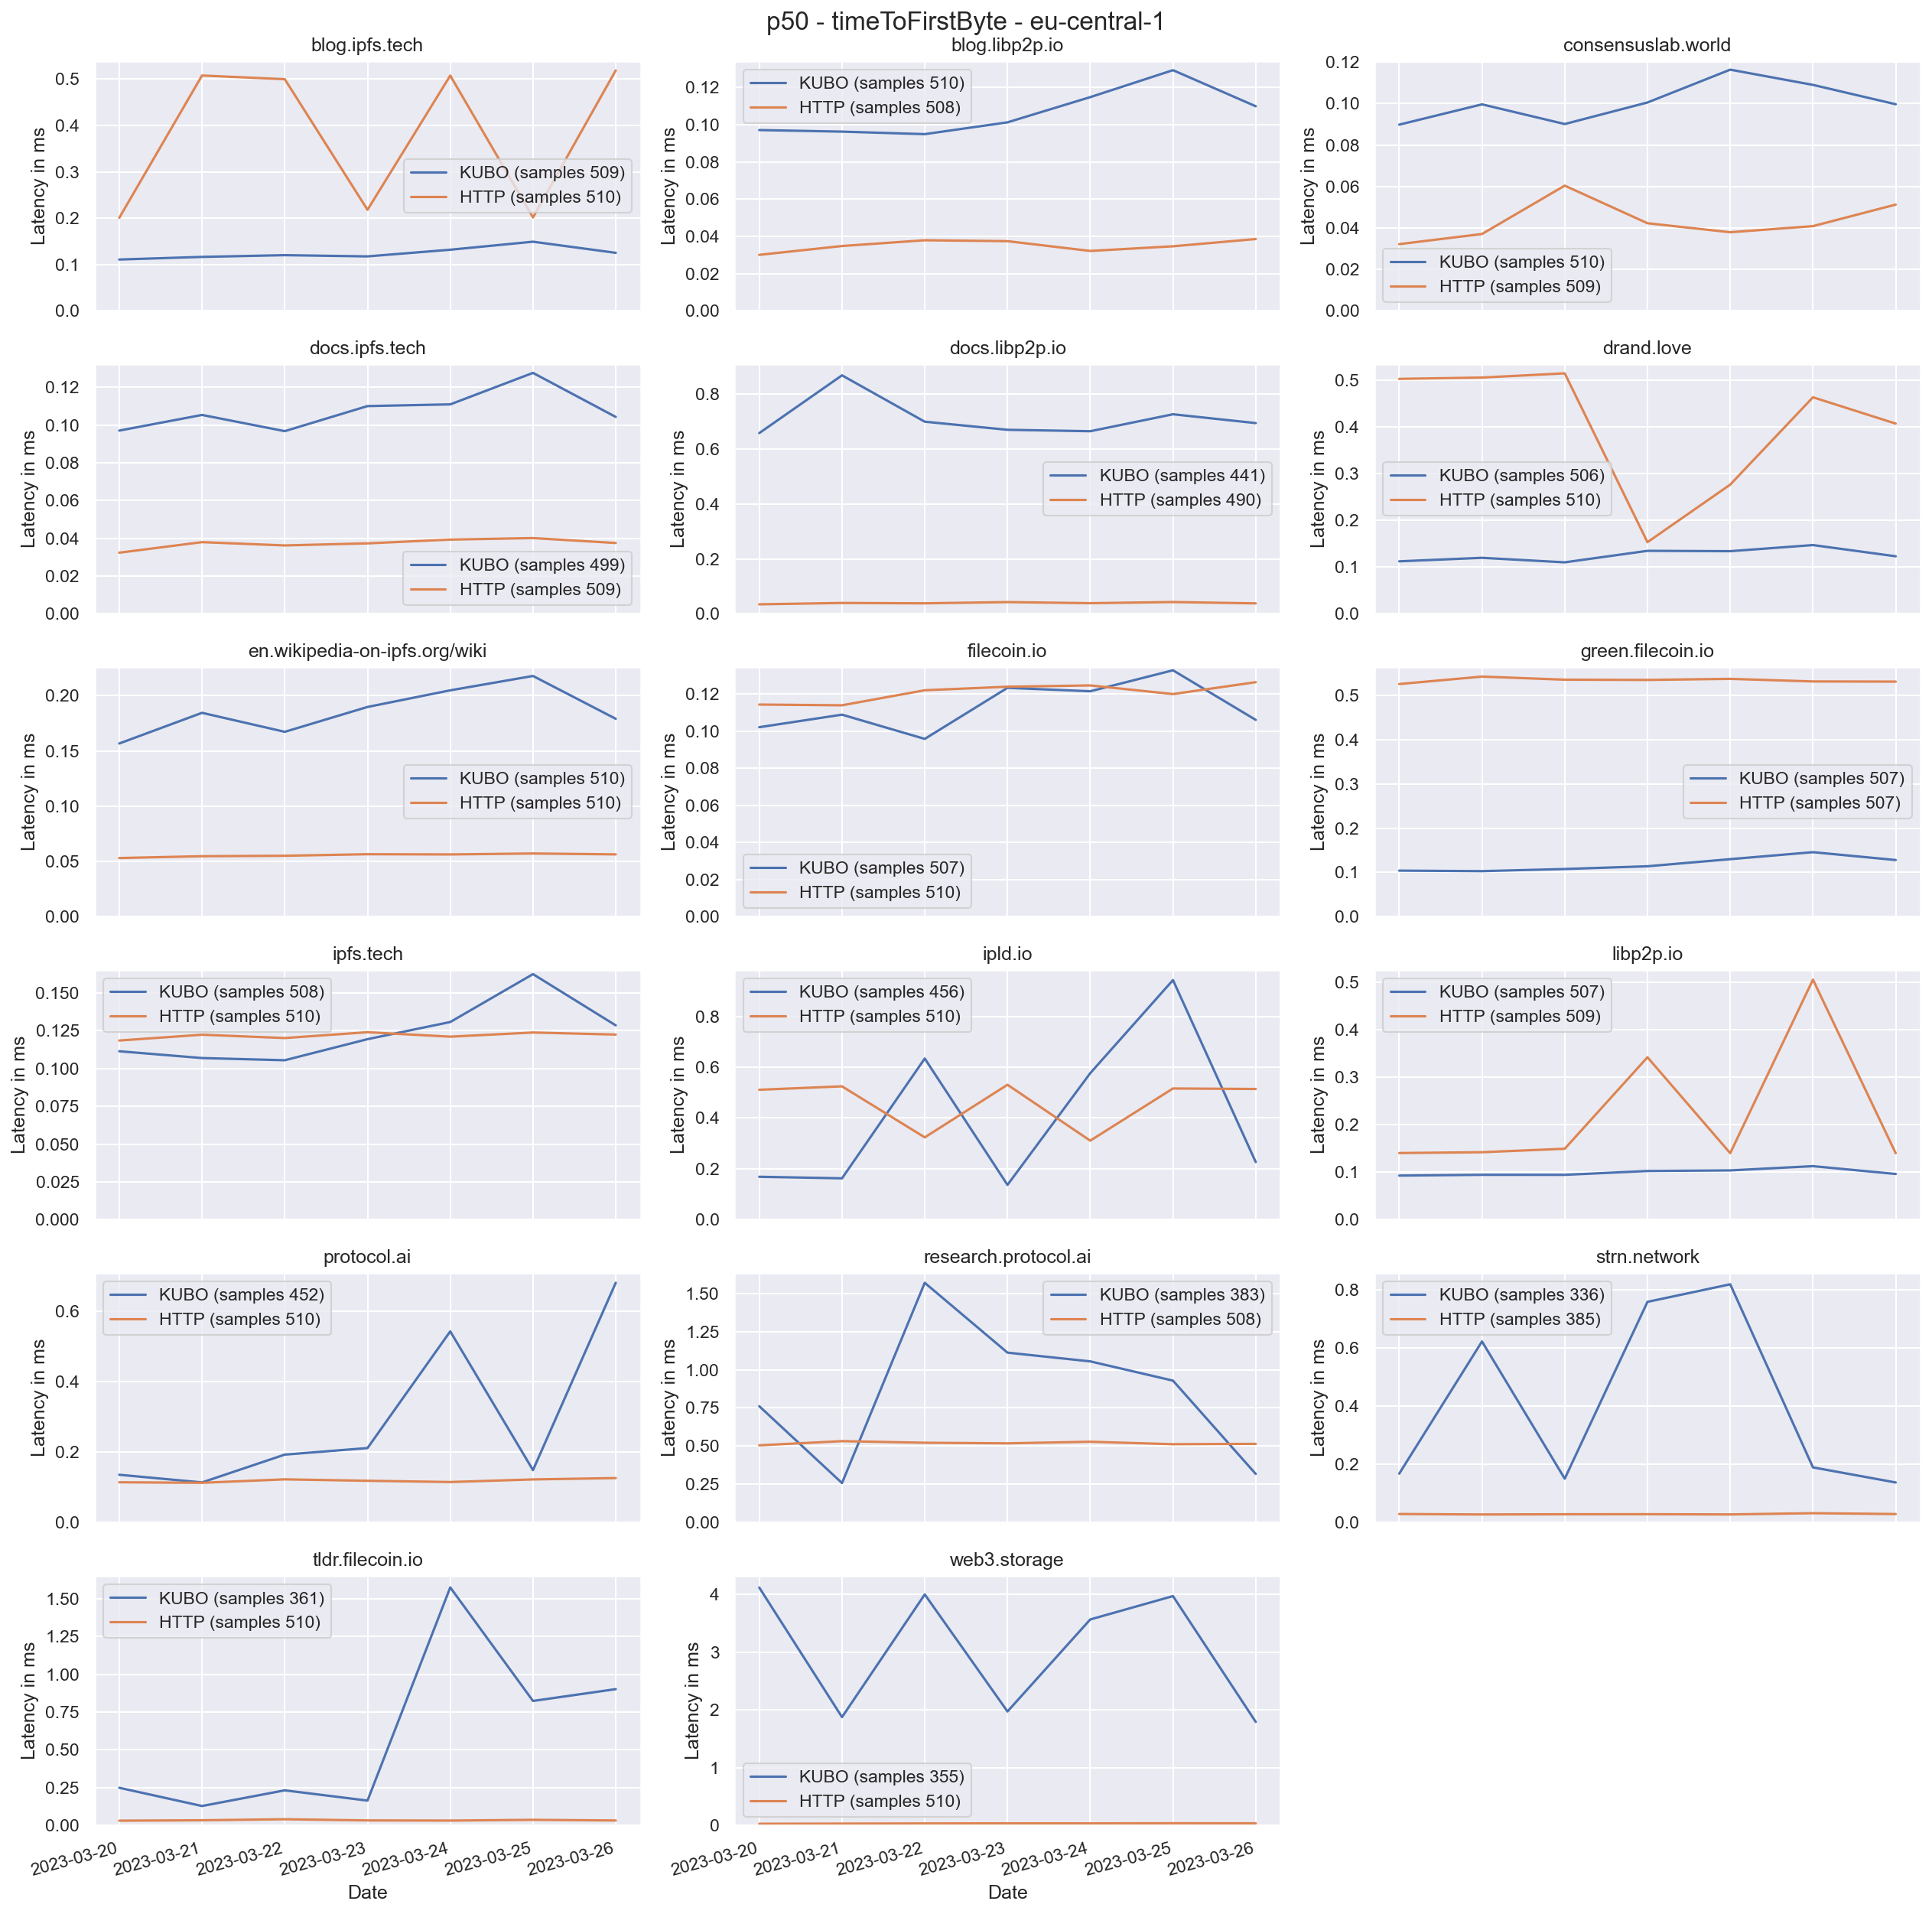

In [48]:
metric = "timeToFirstByte"
region = "eu-central-1"
websites = list(sorted(df["website"].unique()))

fig, axes = plt.subplots(math.ceil(len(websites) / 3), 3, figsize=[17, 17], dpi=150, sharex=True)

for j, website in enumerate(websites):
    ax = fig.axes[j]

    dat = df.copy()
    dat = dat[dat["website"] == website]
    dat = dat[dat["region"] == region]
    dat_http = dat[dat["type"] == "HTTP"]
    dat_kubo = dat[dat["type"] == "KUBO"]

    # twin_ax = ax.twinx()
    # twin_ax.plot(dat_http["created_at"], dat_kubo[metric].to_numpy()/dat_http[metric].to_numpy(), label="Ratio", color="gray")
    # twin_ax.set_ylabel("Ratio KUBO/HTTP")
    # twin_ax.set_ylim(0)
    # twin_ax.grid(False)
    # twin_ax.legend(loc="lower right")

    samples_kubo = \
        df_query[
            (df_query["website"] == website) & (df_query["type"] == "KUBO") & (df_query["region"] == region)].count()[
            "id"]
    samples_http = \
        df_query[
            (df_query["website"] == website) & (df_query["type"] == "HTTP") & (df_query["region"] == region)].count()[
            "id"]

    ax.plot(dat_kubo["created_at"], dat_kubo["ttfb"], label=f"KUBO (samples {samples_kubo})")
    ax.plot(dat_http["created_at"], dat_http["ttfb"], label=f"HTTP (samples {samples_http})")

    ax.set_ylabel("Latency in ms")
    if j + 3 >= len(fig.axes):
        ax.set_xlabel("Date")

    ax.set_ylim(0)
    ax.legend()
    ax.set_title(website)

    for tick in ax.get_xticklabels():
        tick.set_rotation(15)
        tick.set_ha("right")

for j in range(len(websites), len(fig.axes)):
    fig.axes[j].remove()

fig.suptitle(f"p50 - {metric} - {region}", fontsize=16)
fig.set_tight_layout(True)

In [49]:
# df = pd.concat([df_query, pd.json_normalize(df_query['metrics'])], axis=1)

KeyError: 'metrics'

In [50]:
dat_http = df[df["type"] == "HTTP"]
dat_kubo = df[df["type"] == "KUBO"]

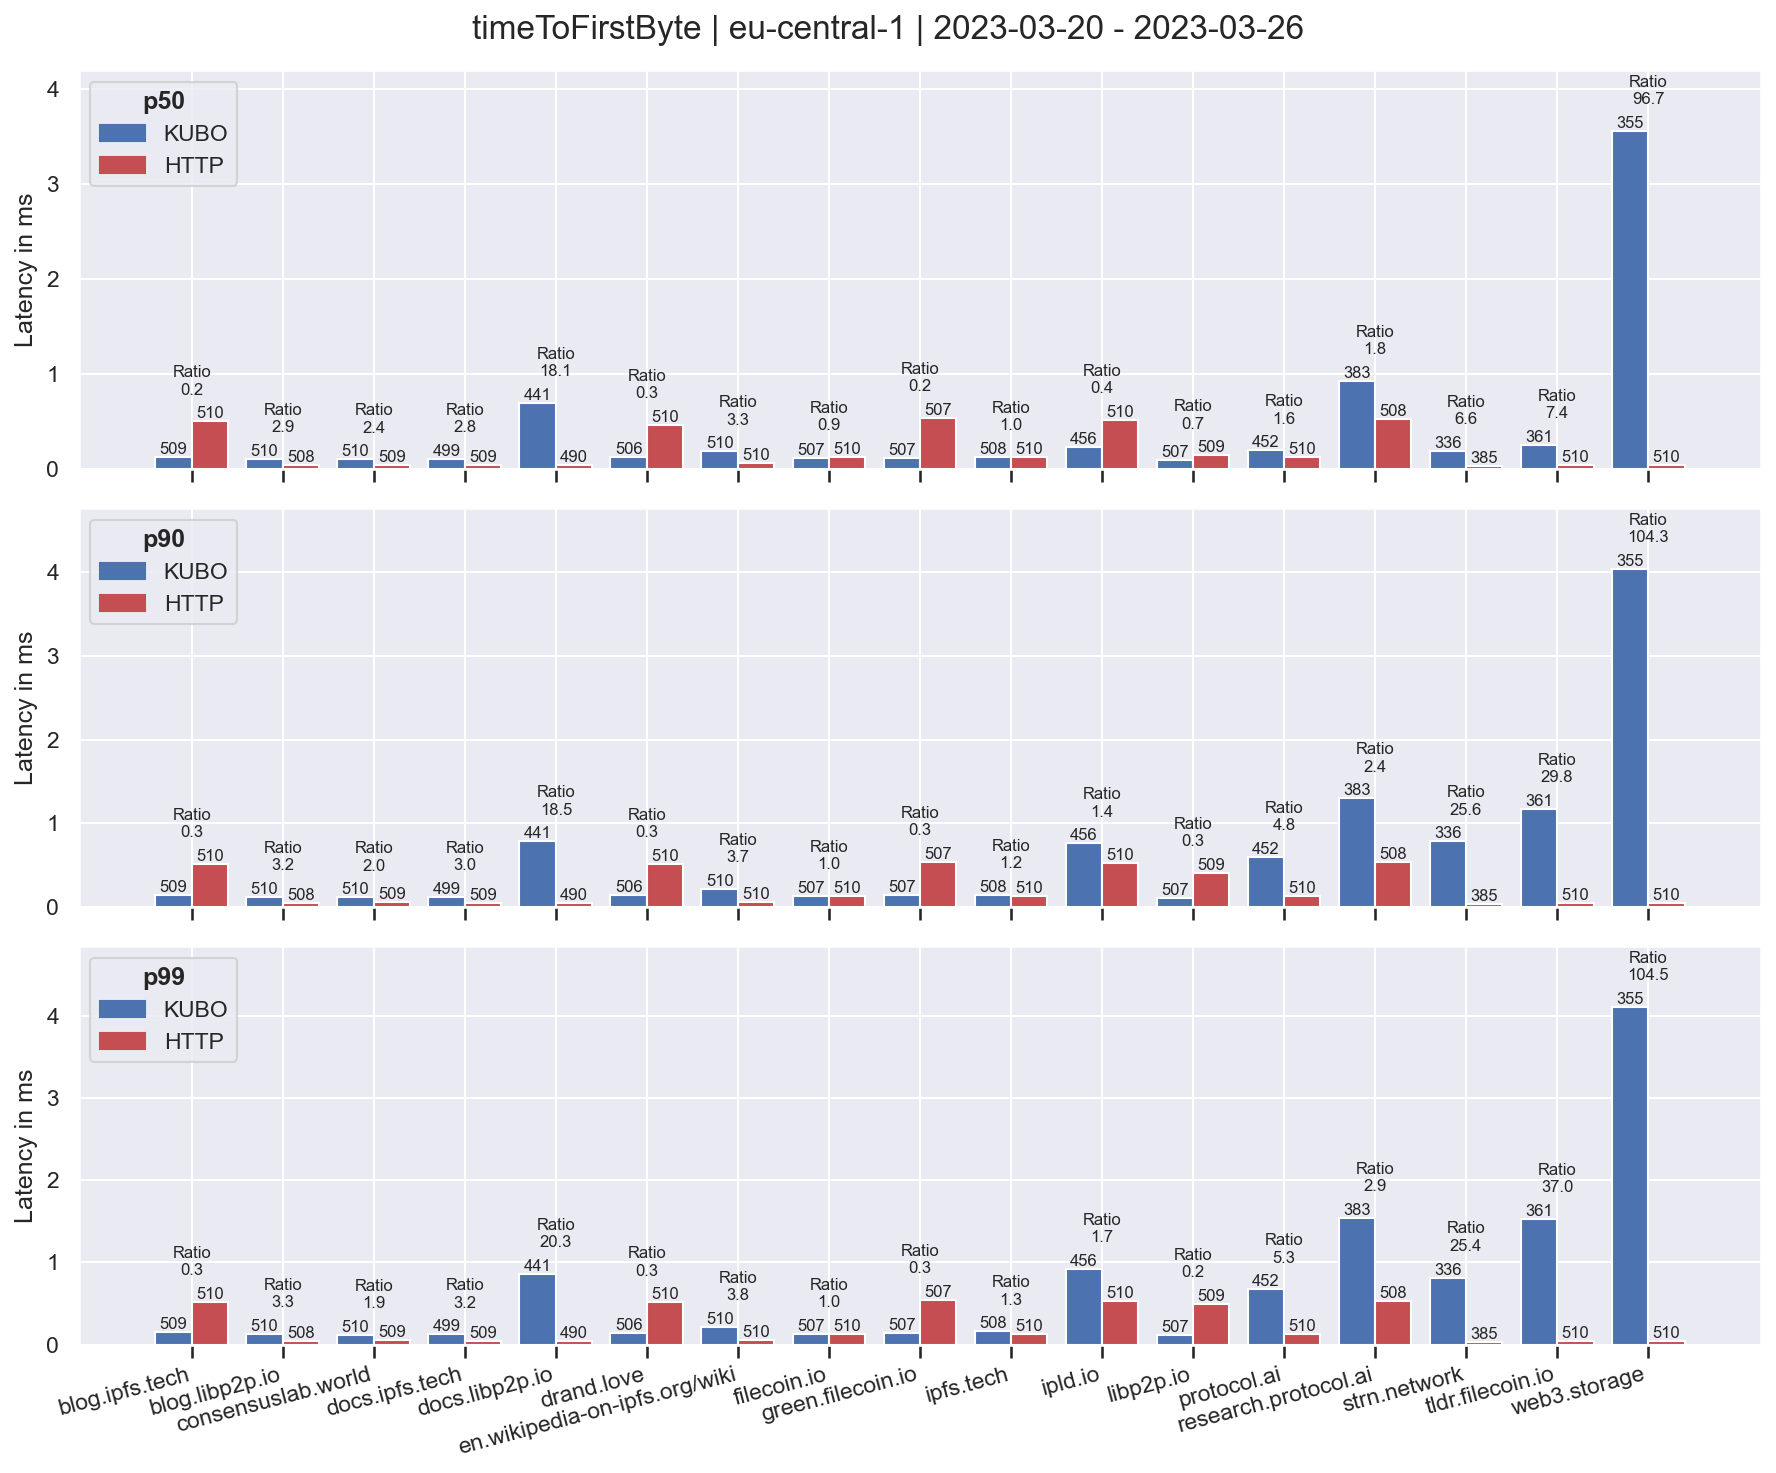

In [51]:
metric = "timeToFirstByte"
region = "eu-central-1"
websites = list(sorted(df["website"].unique()))

fig, ax = plt.subplots(3, 1, figsize=[12, 10], dpi=150, sharex=True)

width = 0.4

for i, percentile in enumerate([50, 90, 99]):
    ax = fig.axes[i]

    grouped = df.groupby(["website", "region", "type"]).quantile(percentile / 100, numeric_only=True).reset_index()[
        ["website", "region", "type", "ttfb"]]

    values = []

    xticks = []
    labels = []
    for j, website in enumerate(websites):
        dat = grouped.copy()
        dat = dat[dat["website"] == website]
        dat = dat[dat["region"] == region]
        dat_http = dat[dat["type"] == "HTTP"]
        dat_kubo = dat[dat["type"] == "KUBO"]

        samples_kubo = df_query[
            (df_query["website"] == website) & (df_query["type"] == "KUBO") & (df_query["region"] == region)].count()[
            "id"]
        kubo_y = dat_kubo["ttfb"].iloc[0]
        p = ax.bar(j - width, kubo_y, color="b", align="edge", label="KUBO", width=width)
        ax.bar_label(p, labels=[samples_kubo], fontsize=8)

        samples_http = df_query[
            (df_query["website"] == website) & (df_query["type"] == "HTTP") & (df_query["region"] == region)].count()[
            "id"]
        http_y = dat_http.reset_index()["ttfb"].iloc[0]
        p = ax.bar(j, http_y, color="r", align="edge", label="HTTP", width=width)
        ax.bar_label(p, labels=[samples_http], fontsize=8)

        values += [kubo_y, http_y]

        xticks += [j]
        labels += [website]

    for j, website in enumerate(websites):
        kubo_y = values[2 * j]
        http_y = values[2 * j + 1]
        ax.text(j, max(kubo_y, http_y) + 0.07 * np.max(values), f"Ratio\n{kubo_y / http_y:.1f}", ha="center",
                va="bottom", fontsize=8)

    ax.tick_params(bottom=True)
    ax.set_xticks(xticks, labels)
    for tick in ax.get_xticklabels():
        tick.set_rotation(15)
        tick.set_ha("right")

    if i + 1 == len(websites):
        ax.set_xlabel("Website")

    ax.set_ylabel("Latency in ms")
    ax.set_ylim(0, np.max(values) + 0.18 * np.max(values))

    legend_elements = [
        Patch(facecolor='b', edgecolor='b', label='KUBO'),
        Patch(facecolor='r', edgecolor='r', label='HTTP')
    ]

    ax.legend(title=f"p{percentile}", handles=legend_elements, loc='upper left',
              title_fontproperties={"weight": "bold"})

fig.suptitle(
    f"{metric} | {region} | {df_query['created_at'].min().strftime('%Y-%m-%d')} - {df_query['created_at'].max().strftime('%Y-%m-%d')}",
    fontsize=16)
fig.set_tight_layout(True)

In [52]:
def get_measurements(conn: sa.engine.Engine, start_date: str, end_date: str) -> pd.DataFrame:
    print("Get measurements...")

    query = f"""
    SELECT
        m.id,
        r.region,
        m.website,
        m.url,
        m.type,
        m.try,
        EXTRACT(EPOCH FROM m.ttfb) ttfb,
        EXTRACT(EPOCH FROM m.fcp) fcp,
        EXTRACT(EPOCH FROM m.lcp) lcp,
        date_trunc('day', m.created_at)::DATE date,
        CASE
            WHEN m.error = 'navigation timed out' THEN
                TRUE
            ELSE
                FALSE
        END has_error,
        m.created_at
    FROM measurements m
        INNER JOIN runs r on m.run_id = r.id
    WHERE m.created_at >= '{start_date}'
      AND m.created_at < '{end_date}'
    ORDER BY m.created_at
    """
    return pd.read_sql_query(query, con=conn)

In [53]:
df_all = get_measurements(conn, '1970-01-01', end_date)

Get measurements...


In [56]:
df_all["monday"] = df_all["created_at"].dt.date - pd.to_timedelta((df_all["created_at"].dt.dayofweek + 6) % 7, unit="D")

/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_4069/412775095.py:1: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  df_all["monday"] = df_all["created_at"].dt.date - pd.to_timedelta((df_all["created_at"].dt.dayofweek + 6) % 7, unit="D")


In [69]:
data = df_all[(df_all["type"] == "KUBO") & (df_all["has_error"] == False)] \
    .groupby(["date", "website"])["ttfb"] \
    .quantile([0.5, 0.9, 0.99]) \
    .unstack() \
    .reset_index()

In [70]:
data

,date,website,0.5,0.9,0.99
0,2023-03-12,blog.ipfs.tech,0.09155,0.13011,0.351038
1,2023-03-12,blog.libp2p.io,0.10275,0.25210,1.157104
2,2023-03-12,consensuslab.world,0.09195,0.18119,0.191933
3,2023-03-12,docs.ipfs.tech,0.08195,0.10409,0.104900
4,2023-03-12,docs.libp2p.io,0.41315,3.71822,3.748382
...,...,...,...,...,...
250,2023-03-26,protocol.ai,0.76550,2.11160,12.514392
251,2023-03-26,research.protocol.ai,0.93820,3.56846,5.333902
252,2023-03-26,strn.network,0.80745,1.55099,15.546712
253,2023-03-26,tldr.filecoin.io,1.20770,7.62963,26.904999


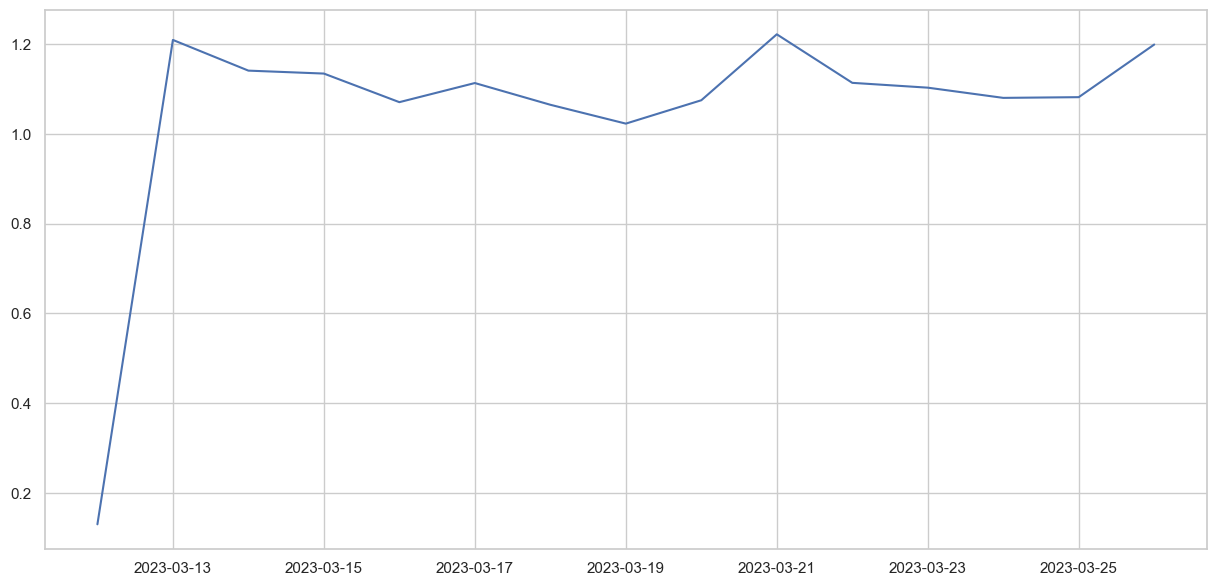

In [72]:
fig, ax = plt.subplots(figsize=[15, 7])

dat = data[data["website"] == "blog.ipfs.tech"]

ax.plot(dat["date"], dat[0.9])